In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2026-01-03 17:39:21.514988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767461961.700996      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767461961.759314      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767461962.217289      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767461962.217338      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767461962.217341      24 computation_placer.cc:177] computation placer alr

## 1. Data Preparation

In [2]:
BASE_PATH = '/kaggle/input/cancer-binary-classes/cancer_data_set' 
data = []
for patient_id in os.listdir(BASE_PATH):
    patient_path = os.path.join(BASE_PATH, patient_id)
    if os.path.isdir(patient_path):
        for label in ['0', '1']: #0=Benign, 1=Malignant
            class_path = os.path.join(patient_path, label)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    data.append({
                        'path': os.path.join(class_path, img_name),
                        'label': 'benign' if label == '0' else 'malignant'
                    })

df = pd.DataFrame(data)
print(f"Total images: {len(df)}")
print(df['label'].value_counts()) #Check for imbalance

#Split data (80% Train, 20% Test)
#We use 'stratify' to keep the same cancer/benign ratio in both sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

Total images: 10879
label
benign       8791
malignant    2088
Name: count, dtype: int64


## 2. Image Generators

In [3]:
IMG_SIZE = (50, 50)
BATCH_SIZE = 32 

#Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2 #Use 20% of training data for validation
)

#Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='validation'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 6963 validated image filenames belonging to 2 classes.
Found 1740 validated image filenames belonging to 2 classes.
Found 2176 validated image filenames belonging to 2 classes.


 ## 3. Model Architecture

In [4]:
base_model = MobileNetV2(input_shape=(50, 50, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid') #Sigmoid for 0/1 classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='sensitivity')]
)

/tmp/ipykernel_24/2269520693.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(50, 50, 3), include_top=False, weights='imagenet')
I0000 00:00:1767462017.108296      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 4. Training with Class Weights

In [5]:
#Calculate weights based on class frequency
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(weights))

#Define Early Stopping
#This will stop training if val_loss doesn't improve for 7 epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1767462024.396194      65 service.cc:152] XLA service 0x7c57c4011de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767462024.396234      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767462025.460839      65 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767462029.702252      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


218/218 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.7408 - loss: 0.5604 - sensitivity: 0.6823 - val_accuracy: 0.8046 - val_loss: 0.4390 - val_sensitivity: 0.8468
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8029 - loss: 0.4473 - sensitivity: 0.7919 - val_accuracy: 0.7626 - val_loss: 0.5112 - val_sensitivity: 0.9081
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7901 - loss: 0.4613 - sensitivity: 0.7873 - val_accuracy: 0.8460 - val_loss: 0.3423 - val_sensitivity: 0.7521
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.8203 - loss: 0.4120 - sensitivity: 0.8046 - val_accuracy: 0.8569 - val_loss: 0.3587 - val_sensitivity: 0.7911
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.8213 - loss: 0.4121 - sensitivity: 0.8000 - val_accuracy: 0.8534 - val_loss: 0.3460 - val_sensitivity: 0.7799
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8253 - loss: 0.4081 - sensitivity: 0.8099 - val_accu

## 5. Final Evaluation

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

#predictions
preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype(int)
y_true = test_gen.classes

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

sensitivity = tp / (tp + fn) #Recall
specificity = tn / (tn + fp) #Specificity

print(f"Sensitivity (Recall): {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")
print("\nDetailed Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step
Sensitivity (Recall): 80.38%
Specificity: 83.56%

Detailed Report:
               precision    recall  f1-score   support

      Benign       0.95      0.84      0.89      1758
   Malignant       0.54      0.80      0.64       418

    accuracy                           0.83      2176
   macro avg       0.74      0.82      0.77      2176
weighted avg       0.87      0.83      0.84      2176



## Plots

### 1. Training & Validation History

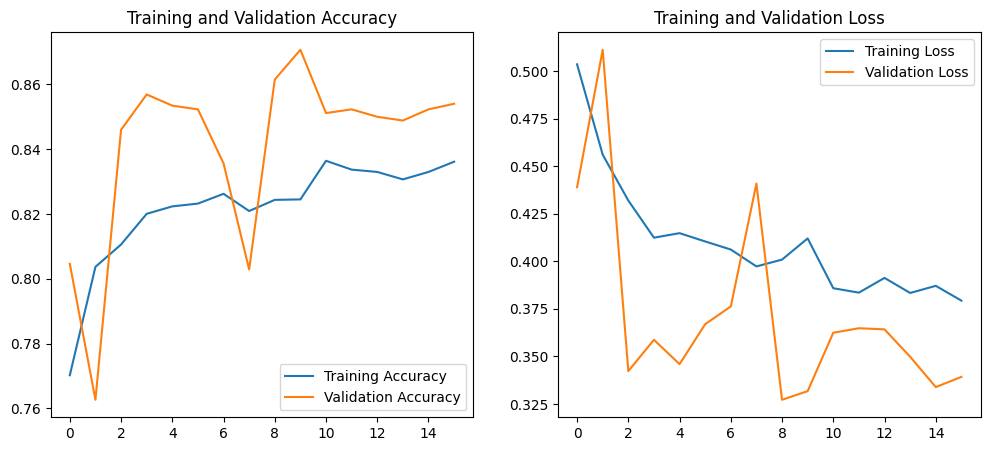

In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    #Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    #Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    
    plt.show()

plot_history(history)

### 2. Confusion Matrix Heatmap

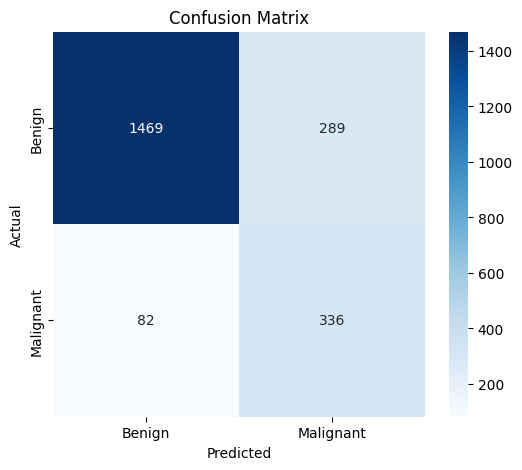

In [8]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'], 
                yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred)

### 3. ROC Curve

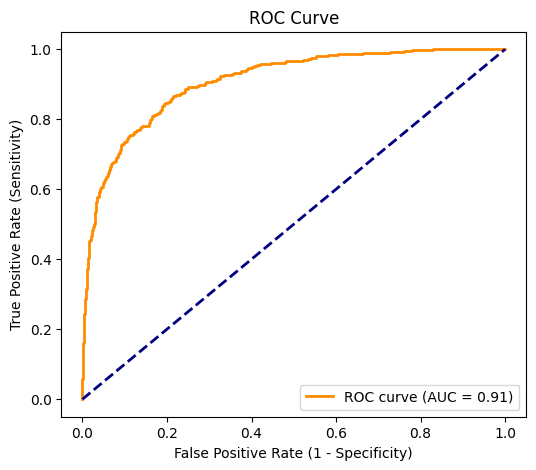

In [9]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, preds):
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_true, preds)

## saving the model run

In [10]:
model.save("cnn_model.h5")

## calling the model and use it

In [11]:
model = load_model("cnn_model.h5")